In [1]:
using CSV, DataFrames, Plots
dat = CSV.read("../processed_data/kelp_bins_50_1000m_cenca_model_2.csv",DataFrame)[:,vcat([2],4:(end-1))]
dat1 = CSV.read("../processed_data/kelp_bins_50_1000m_cenca_model_2.csv",DataFrame)[:,3]
dat2 = CSV.read("../processed_data/kelp_bins_50_1000m_cenca_model_2.csv",DataFrame)[:,end]
dat[:,2:end] .= log.(dat[:,2:end] .+ 1e-2)
dat[1:4,:]

Row,year,lat_36_00900,lat_36_01800,lat_36_02700,lat_36_03600,lat_36_04500,lat_36_05399,lat_36_06299,lat_36_07199,lat_36_08099,lat_36_08999,lat_36_09899,lat_36_10799,lat_36_11698,lat_36_12598,lat_36_13498,lat_36_14398,lat_36_15298,lat_36_16198,lat_36_17098,lat_36_17997,lat_36_18897,lat_36_19797,lat_36_20697,lat_36_21597,lat_36_22496,lat_36_23396,lat_36_24296,lat_36_25196,lat_36_26096,lat_36_26995,lat_36_27895,lat_36_28795,lat_36_29695,lat_36_30595,lat_36_31494,lat_36_32394,lat_36_33294,lat_36_34194,lat_36_35093,lat_36_35993,lat_36_36893,lat_36_37793,lat_36_38692,lat_36_39592,lat_36_40492,lat_36_41391,lat_36_42291,lat_36_43191
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1984,-2.58789,-2.66111,-3.42609,-2.26823,-4.60517,-4.60517,-1.07275,-1.50767,-1.40117,-4.27319,-1.24491,-1.45304,-1.76438,-1.90084,-1.53039,-1.88512,-1.52516,-1.32336,-1.759,-3.13265,-4.60517,-0.707713,-1.21978,-0.602308,-0.669124,-4.60517,-4.60517,-4.4744,-2.43743,-1.27773,-1.27661,-2.1077,-1.28094,-4.60517,-4.60517,-3.74464,-2.98172,-2.1572,-2.31481,-1.62674,-2.30302,-2.28859,-1.41931,-1.35847,-2.34493,-2.06928,-2.25645,-1.59122
2,1985,-0.405763,-0.361271,-0.783275,-0.179105,-1.00457,-4.60517,-0.154149,-0.115173,0.00995033,-1.23007,-0.030953,0.00995033,-0.0124954,-0.0429771,0.00995033,0.00995033,-0.110543,-0.343452,-0.363259,-0.6809,-3.97851,0.00995033,0.00995033,0.00995033,0.00995033,-4.60517,-4.60517,-1.18644,-0.427359,0.00995033,0.00995033,0.00995033,0.00995033,-2.87493,-0.214453,-0.523556,-0.129413,0.00995033,-1.03685,-0.192878,-0.141602,-0.140622,0.00995033,0.00995033,-0.000571319,0.00995033,0.00995033,0.00995033
3,1986,-0.975074,-0.639996,-0.99287,-1.60281,-3.80866,-4.60517,-1.70205,-1.86,-1.33691,-2.62061,-1.12678,-0.931189,-2.0448,-1.8182,-1.70447,-1.06707,-1.81196,-1.44144,-1.42635,-0.891047,-1.65437,-1.47921,-1.84273,-1.01349,-1.00029,-4.60517,-4.60517,-0.873118,-0.559407,-0.43915,-0.471501,-0.457372,-0.446434,-2.49933,-2.72671,-0.16141,0.00995033,-0.0245003,-0.414582,-0.28672,-0.311997,-0.175793,-0.202474,-0.0759782,-0.728727,-0.41201,-0.28075,-0.218542
4,1987,-0.852962,-0.580453,-0.804242,-1.11163,-2.63243,-4.60517,-0.740328,-0.847091,-0.736896,-2.85309,-0.927404,-0.99109,-1.08995,-1.19331,-1.2507,-0.986599,-0.947988,-0.778686,-0.672869,-0.438258,-0.579667,-0.590385,-0.624151,-0.258459,-0.508997,-4.60517,-4.60517,-0.353178,-0.394563,-0.479102,-1.0358,-0.860156,-1.19359,-4.60517,-2.44741,-0.39823,-0.692344,-0.725691,-1.13601,-1.07872,-0.89104,-0.384143,-0.443423,-0.372117,-1.43795,-1.62279,-0.750183,-0.651819


In [2]:
dat_K = CSV.read("../processed_data/kelp_bins_50_1000m_cenca_model_2_K.csv",DataFrame)[:,4:(end-1)]
K1 = CSV.read("../processed_data/kelp_bins_50_1000m_cenca_model_2_K.csv",DataFrame)[:,3]
K2 = CSV.read("../processed_data/kelp_bins_50_1000m_cenca_model_2_K.csv",DataFrame)[:,end]
K = Matrix(dat_K)[1,:]
K

48-element Vector{Float64}:
 0.490329251586423
 0.192013562666975
 0.174772716271643
 0.0616618466011978
 0.00273691073751959
 6.18181415250536e-5
 0.146916645234434
 0.0926974695968466
 0.0703863692164317
 0.0749784073897173
 ⋮
 0.0378122909628292
 0.010403526666655
 0.0200197468138872
 0.0439346197338671
 0.0558742688984182
 0.0318532553958198
 0.0287792608299844
 0.177092646148876
 0.137027492160468

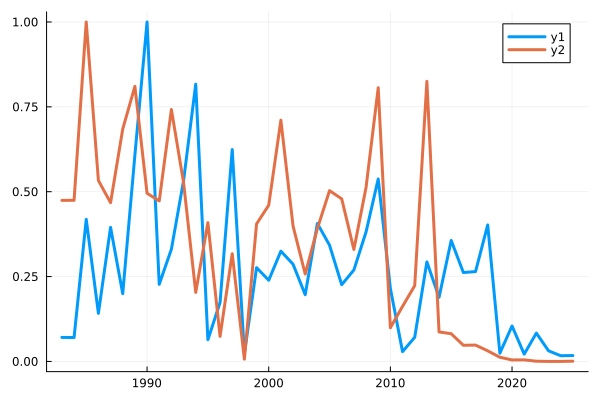

In [3]:
using Statistics
mu_t1 = dat1
mu_t1 = vcat([mean(mu_t1)],mu_t1,[mean(mu_t1)])
years = vcat([1500],dat.year, [2500])

mu_t2 = dat2
mu_t2 = vcat([mean(mu_t2)],mu_t2,[mean(mu_t2)])
years = vcat([1500],dat.year, [2500])

function mu(t,mu_t)
    ind_lower = maximum(eachindex(years)[years .<= t])
    ind_upper = minimum(eachindex(years)[years .> t])
    t_lower = years[ind_lower]
    t_upper = years[ind_upper]
    mu_lower = mu_t[ind_lower]
    mu_upper = mu_t[ind_upper]

    mu = mu_lower + (t-t_lower)/(t_upper-t_lower)*(mu_upper-mu_lower)
    return mu
end 
tvals = 1983:0.25:2025
Plots.plot(tvals, broadcast(t ->mu(t,mu_t1), tvals), linewidth = 3)
Plots.plot!(tvals, broadcast(t ->mu(t,mu_t2), tvals), linewidth = 3)

In [4]:
X = CSV.read("../processed_data/covars.csv",DataFrame)[:,:2:end]
X[1:4,:]

Row,year,variable,value
,Float64,String7,Float64
1,1980.0,enso,0.33
2,1980.08,enso,0.2
3,1980.17,enso,0.39
4,1980.25,enso,0.51


In [5]:
include("../src/UDE2.jl")
model, NN = init_model(dat,X,K,t -> mu(t,mu_t1),t -> mu(t,mu_t2),K1,K2,1,[2];hidden = 10)
nothing

In [13]:
function training!(model,reg_weight)
α = UniversalDiffEq.train!(model, loss_function = "spline gradient matching", regularization_weight = reg_weight, 
        optim_options = (maxiter = 500, step_size = 0.05), loss_options = (σ = 0.05^2, τ = 0.05^2, T = 160))
end
training!(model,1e4)
nothing

162
1.437194104965e9 1.435665147558e9 1.506564503303e9 1.435063168041e9 1.393120911128e9 1.41464159872e9 1.383421330797e9 1.347554227769e9 1.33622586346e9 1.329205721136e9 1.315626216447e9 1.300420825569e9 1.284512810944e9 1.266129578891e9 1.251493113136e9 1.242336682527e9 1.229361666243e9 1.211518827896e9 1.19667088061e9 1.18262641134e9 1.168009409039e9 1.155311427843e9 1.139487167522e9 1.124914200178e9 1.111897816706e9 1.096607095286e9 1.083443742107e9 1.067964113447e9 1.055390426884e9 1.040656657787e9 1.027834137725e9 1.012969909125e9 1.000473135116e9 9.86127012513e8 9.73591059287e8 9.60048600912e8 9.46417989686e8 9.34244573997e8 9.20997812926e8 9.08268102577e8 8.96118404646e8 8.8329394728e8 8.70731685406e8 8.58961509033e8 8.46943258574e8 8.34462039117e8 8.22396172245e8 8.11022390424e8 7.99921232952e8 7.88749521502e8 7.77323093571e8 7.6582973818e8 7.54537304856e8 7.43677696236e8 7.331826167e8 7.23069478862e8 7.13737443054e8 7.05515257049e8 6.97538264382e8 6.85490450855e8 6.724639572

In [14]:
using JLD2
save_object("../results/parameters/model2_1km_0.05_1e4.jld",model.parameters)

In [15]:
rhs = UniversalDiffEq.get_right_hand_side(model)
f_rhs = (u,X,site) -> rhs(zeros(length(K)) .+ u  , [X,X], 2000.0)[site]
f_rhs(0.0,0.0,2)

-0.16777435738907792

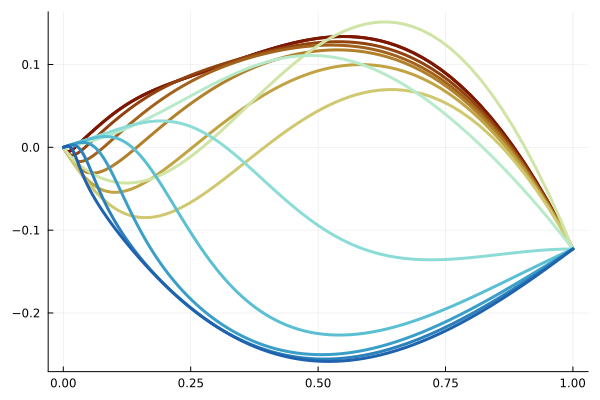

In [27]:
Xvals = -3:0.5:3; site = 30
uvals = -8.0:0.025:0.0
colors = cgrad(:roma)[1:round(Int,256/length(Xvals)-1):256]
p1 = Plots.plot(exp.(uvals),exp.(uvals).*f_rhs.(uvals,Xvals[1],site), color = colors[1], label = "",width=3)
i = 0
for X in Xvals
    i += 1
    Plots.plot!(p1,exp.(uvals),exp.(uvals).*f_rhs.(uvals,X,site), color = colors[i], label = "",width=3)
end
p1

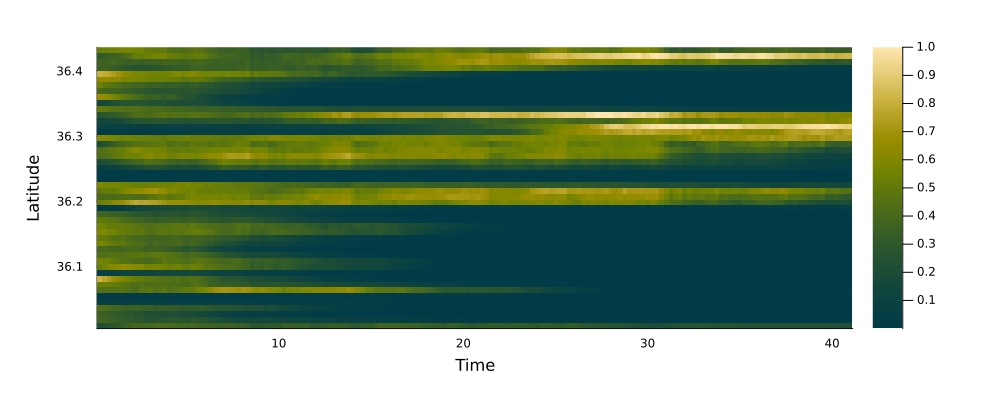

In [30]:
u = model.parameters.uhat[:,1]
X = [0.0,0.0] .+ -2.0
T = 2025-1984
dt = 0.25
uvals = zeros(length(K), round(Int,T/dt))
i = 0
for t in (1984+dt):dt:2025
    i+=1
    u[u.>0] .= 0
    uvals[:,i] = u
    X = model.process_model.covariates(t)
    u = u + dt*rhs(u,X,t).+sqrt(dt)*0.05*randn(length(K))
end

function get_latitude(nm)
m = match(r"(?<integer>\d+)_(?<decimal>\d+)",nm)
parse(Float64,(m[:integer])) + parse(Float64,(string("0.",m[:decimal])))
end 

lats = get_latitude.(names(dat[:,2:end]))

using Plots.PlotMeasures
Plots.heatmap(dt:dt:T,lats,exp.(uvals), c= :bamako, size = (1000,400),
ylabel = "Latitude", xlabel = "Time", margin = 10mm)

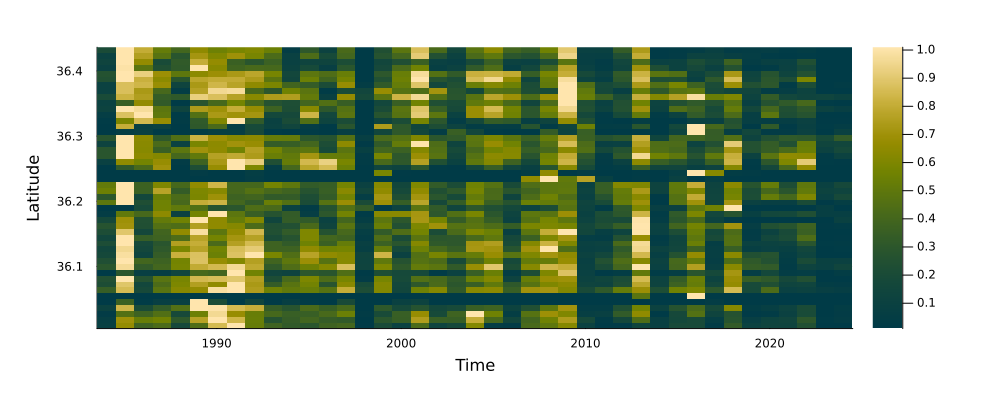

In [22]:
Plots.heatmap(dat.year,lats,exp.(Matrix(dat[:,2:end]))', c= :bamako, size = (1000,400),
ylabel = "Latitude", xlabel = "Time", margin = 10mm)

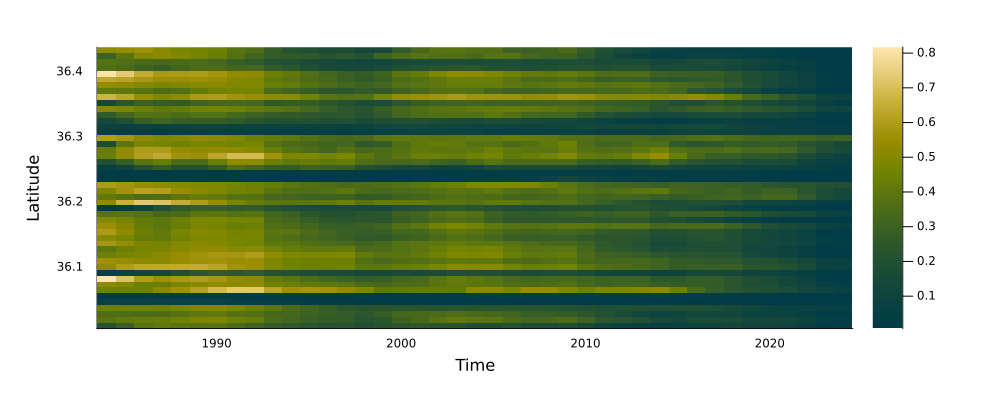

In [23]:
Plots.heatmap(dat.year,lats,exp.(Matrix(model.parameters.uhat)), c= :bamako, size = (1000,400),
ylabel = "Latitude", xlabel = "Time", margin = 10mm)